# LSTM Based RNN for Sentiment Gauging from Tweets

This notebook is to illustrate sentiment gauging from tweets.

In [19]:
# Import the required libraries

%tensorflow_version 2.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import InputLayer
from keras.optimizers import SGD,Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Read data from the CSV file

data = pd.read_csv("TheSocialDilemma.csv")

In [4]:
# Examine the content of the dataframe

data.head(5)

,text,Sentiment
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,Neutral
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,Positive
3,I watched #TheSocialDilemma last night. I’m sc...,Negative
4,The problem of me being on my phone most the t...,Positive


**Note:**

Max tweet length has also been identified as not exceeding 40 words.

In [5]:
# Read and process glove vectors

# Open the glove vectors text file in read mode
f = open("glove.6B.50d.txt",'r')

# Initialize index variable to zero
ind = 0

# Initialize dictionaries to store the representations
word_to_index = {}
index_to_word = {}
word_to_vec_map = {}

# For loop to iterate through the lines read from the file
for line in f:
  # Split the line read, to read the words and vector representations
  splitLines = line.split()
  # Store the word in a variable
  word = splitLines[0]
  # Store the word vectors in a numpy array
  wordEmbedding = np.array([float(value) for value in splitLines[1:]])

  # Write to the dictionaries
  word_to_index[word] = ind
  index_to_word[ind] = word
  word_to_vec_map[word] = wordEmbedding

  # Increment the index
  ind = ind + 1

In [6]:
# Examine the dictionaries

print("Length of word to index dict is : ", len(word_to_index))
print("Length of index to word dict is : ", len(index_to_word))
print("Length of word to vector dict is: ",len(word_to_vec_map))
print("Index of happy is: ", word_to_index["happy"])
print("Word at index 25 is: ", index_to_word[25])
print("\n")
print("Word vector for happy is: ", word_to_vec_map["happy"])

Length of word to index dict is :  400000
Length of index to word dict is :  400000
Length of word to vector dict is:  400000
Index of happy is:  1751
Word at index 25 is:  from


Word vector for happy is:  [ 0.092086  0.2571   -0.58693  -0.37029   1.0828   -0.55466  -0.78142
  0.58696  -0.58714   0.46318  -0.11267   0.2606   -0.26928  -0.072466
  1.247     0.30571   0.56731   0.30509  -0.050312 -0.64443  -0.54513
  0.86429   0.20914   0.56334   1.1228   -1.0516   -0.78105   0.29656
  0.7261   -0.61392   2.4225    1.0142   -0.17753   0.4147   -0.12966
 -0.47064   0.3807    0.16309  -0.323    -0.77899  -0.42473  -0.30826
 -0.42242   0.055069  0.38267   0.037415 -0.4302   -0.39442   0.10511
  0.87286 ]


In [7]:
# Function to convert an array of sentences to indices after preprocessing

def sentences_to_indices(X, word_to_index, max_len = 40):

  # Identify No. of sentences in the input
  m = len(X)
  # Initialize the indices array to zeros based on the dimensions
  X_indices = np.zeros((m, max_len))

  # For loop to iterate through the elements of the array one by one
  for i in range(m):

    # 1. Remove old style retweet text
    X[i] = re.sub(r'^RT[\s]+', '', X[i])
    # 2. Remove hyperlinks
    X[i] = re.sub(r'https?:\/\/.*[\r\n]*', '', X[i])
    # 3. Remove hashtags
    X[i] = re.sub(r'#', '', X[i])
    # 4. Remove numbers
    X[i] = re.sub(r'[0-9]', '', X[i])
    # 5. Convert to lower case
    X[i] = str(X[i]).lower()
    # 6. Remove punctuations
    X[i] = re.sub(r'[^\w\s]', '', X[i]) 
    # 7. Remove new line
    X[i] = re.sub(r'[\n]', ' ', X[i])
    # 8. Remove underscore
    X[i] = re.sub(r'[_]', '', X[i])

    # Split the sentence to words
    sentence_words = X[i].lower().split()

    # Initialize the word counter to zero
    j = 0
    # For loop to iterate through the words in each of the sentences
    for w in sentence_words:
      # Update the indices array with the index of the word at the required position
      # If a word does not exist in the array, treat it as unknown ('unk')
      if (w in word_to_index):
        X_indices[i, j] = word_to_index[w]
      else:
        X_indices[i, j] = word_to_index['unk']
      j = j + 1
  
  # Return the indices array
  return X_indices

In [8]:
# Function to create the pretrained embedding layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index):

  # Initialize the vocabulary length
  vocab_len = len(word_to_index) + 1
  # Extract max vector dimension
  emb_dim = word_to_vec_map["happy"].shape[0]
  # Initialize a numpy array with zeros for the embedding layer
  emb_matrix = np.zeros((vocab_len, emb_dim))

  # Iterate through every word and get the vector representation
  for word, idx in word_to_index.items():
    emb_matrix[idx, :] = word_to_vec_map[word]

  # Create the Keras embedding layer
  embedding_layer = Embedding(vocab_len, emb_dim)
  # Make the embedding layer non-trainable
  embedding_layer.build((None,))

  # Set the weights based on the vectors read previously
  embedding_layer.set_weights([emb_matrix])

  # Return the embedding layer
  return embedding_layer

In [32]:
# Compose the LSTM based model

# Compose the Input layer
# Set max length based on the value determined previously
sentence_indices = Input(shape = 40, dtype = "int32")

# Fetch the word embeddings as the embedding layer
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

# Set the embedding layer as part of the model
embeddings = embedding_layer(sentence_indices)

# LSTM layer 1
X = LSTM(units = 128, return_sequences= True)(embeddings)
# Dropout layer 1
X = Dropout(0.5)(X)
# LSTM layer 2
X = LSTM(units = 128, return_sequences= False)(X)
# Dropout layer 2
X = Dropout(0.5)(X)

# Output layer for 3 classes with softmax activation
X = Dense(units = 3)(X)
X = Activation('softmax')(X)

# Compose model
model = Model(inputs = sentence_indices, outputs = X)

# Compile and summarize the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 50)            20000050  
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 128)           91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387 

In [11]:
# Compose the train and test datasets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['Sentiment'], test_size = 0.2, random_state = 100)

In [12]:
# Examine the train and test sets for sanity

print("No. of train tweets: ", len(X_train))
print("No. of test tweets: ", len(X_test))
print("No. of train tweet sentiments: ", len(y_train))
print("No. of test tweet sentiments: ", len(y_test))

No. of train tweets:  16054
No. of test tweets:  4014
No. of train tweet sentiments:  16054
No. of test tweet sentiments:  4014


In [21]:
# Convert the train tweets in to indices
X_train_indices = sentences_to_indices(list(X_train), word_to_index, 40)

# Initialize the onehot encoder frok sklearn
enc = OneHotEncoder(sparse = False)
enc.fit(np.array(list(y_train)).reshape(-1, 1))

# Convert the train labels to one hot vectors
y_train_oh = enc.transform(np.array(y_train).reshape(-1, 1))

In [25]:
# Convert the test tweets in to indices
X_test_indices = sentences_to_indices(list(X_test), word_to_index, 40)

# Convert the test labels to one hot vectors
y_test_oh = enc.transform(np.array(y_test).reshape(-1, 1))

In [33]:
# Fit the model

history = model.fit(X_train_indices, y_train_oh, epochs = 50, batch_size = 64, shuffle = True)

Epoch 1/50
251/251 [==============================] - 46s 176ms/step - loss: 0.9883 - accuracy: 0.5119
Epoch 2/50
251/251 [==============================] - 44s 175ms/step - loss: 0.6592 - accuracy: 0.7385
Epoch 3/50
251/251 [==============================] - 44s 175ms/step - loss: 0.4652 - accuracy: 0.8365
Epoch 4/50
251/251 [==============================] - 44s 176ms/step - loss: 0.3138 - accuracy: 0.8941
Epoch 5/50
251/251 [==============================] - 44s 175ms/step - loss: 0.2420 - accuracy: 0.9303
Epoch 6/50
251/251 [==============================] - 44s 175ms/step - loss: 0.1896 - accuracy: 0.9470
Epoch 7/50
251/251 [==============================] - 44s 175ms/step - loss: 0.1457 - accuracy: 0.9586
Epoch 8/50
251/251 [==============================] - 44s 175ms/step - loss: 0.1332 - accuracy: 0.9645
Epoch 9/50
251/251 [==============================] - 44s 175ms/step - loss: 0.1147 - accuracy: 0.9698
Epoch 10/50
251/251 [==============================] - 44s 175ms/step - l

In [34]:
# Evaluate model on test data set

loss, acc = model.evaluate(X_test_indices, y_test_oh)
print()

print("Test accuracy = ", (acc * 100), " %")

126/126 [==============================] - 1s 5ms/step - loss: 0.5710 - accuracy: 0.9205

Test accuracy =  92.05281734466553  %


In [35]:
# Save the model as a h5 file

model.save("rnn_LSTM_sentiment_model.h5")

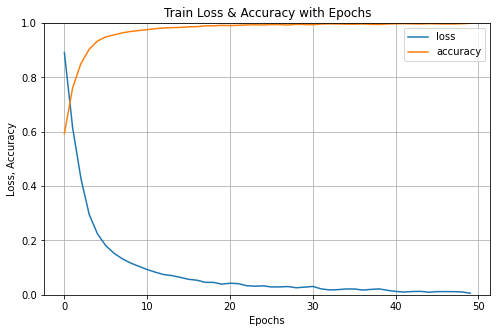

In [38]:
# Plot the performance of model 1 on train dataset

import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel("Epochs")
plt.ylabel("Loss, Accuracy")
plt.title("Train Loss & Accuracy with Epochs")
plt.show()

**Conclusion**

The LSTM model was trained using glovevector weights. On the test set, an accuracy of 92% was obtained.

A similar approach can be used for gauging and classifying sentiments from any textual data.